# LSTM

## Imports

In [1]:
# read & manipulate data
import keras_tuner as kt
import os
import numpy as np
import pandas as pd 
import random as rn
import sys
sys.path.append("../scripts")
import tensorflow as tf
import utils

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

In [2]:
# Model paths
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
tuner_path = '/Users/junxingli/Desktop/master_thesis/models/lstm/'
proj_name = 'whole-V3/'
best_model_path = tuner_path + proj_name + 'best_model'

# Figure paths
overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/lstm/'
plots_path = figs_path + proj_name

In [5]:
def create_sequences(X, y, time_steps):
    ts = X['Time'].values[time_steps:]
    X = X.drop('Time', axis=1).values
    y = y.drop('Time', axis=1).values

    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(np.hstack([X[i:(i+time_steps)], y[i:(i+time_steps)]]))
        ys.append(y[i+time_steps])

    return np.array(Xs), np.array(ys).reshape(-1, 1), np.array(ts)

def run_preprocessing(case='whole_data'):
    df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")
    
    if case == "only_stable":
        df = df[df['Status'] == 'Stable']

    X = df.drop(['Status', 'SRD', 'T5'], axis=1)
    y = df[['Time', 'SRD']]

    cutoff_date = "2020-06-15 00:00"
    X_train = X[X["Time"] < cutoff_date].copy()
    X_test = X[X["Time"] > cutoff_date].copy()
    y_train = y[y["Time"] < cutoff_date].copy()
    y_test = y[y["Time"] > cutoff_date].copy()

    # Standard scaling the data
    scaler = StandardScaler()
    cols = [col for col in X_train.columns if col != 'Time']
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])

    # Need to reshape since the scaler expects a 2D array
    y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
    y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

    return X_train, y_train, X_test, y_test, scaler

# Create sequences for LSTM
time_steps = 15
X_train, y_train, X_test, y_test, scaler = run_preprocessing(case='whole_data')
X_train_seq, y_train_seq, times_train = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq, times_test = create_sequences(X_test, y_test, time_steps)

input_dim = X_train_seq.shape[-1]
output_dim = y_train_seq.shape[-1]

# LSTM

In [12]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        keras.backend.clear_session()
        # Hyperparameters
        hp_layers = hp.Int('num_layers', 1, 3) 
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
        hp_optimizer = hp.Choice('optimizer', values=['adam']) #'SGD', 'rmsprop'])
        hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        
        model = Sequential()
        model.add(Input(shape=(time_steps, input_dim)))
        # Only the last LSTM layer has return_sequences=False
        for i in range(hp_layers):
            if i < hp_layers - 1:
                return_sequences = True
            else:
                return_sequences = False
            
            hp_units = hp.Int('num_units_' + str(i), min_value=60, max_value=200, step=10)
            hp_dropout = hp.Float('dropout_rate_' + str(i), min_value=0, max_value=0.40, step=0.1)
            
            model.add(LSTM(units=hp_units, 
                           activation=hp_activation, 
                           return_sequences=return_sequences))
            if hp_dropout > 0:
                model.add(Dropout(rate=hp_dropout))

        model.add(Dense(1, activation='linear'))
        
        # Select optimizer  
        optimizer_dict = {
            'adam': keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
            'SGD': keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
            'rmsprop': keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate)
        }
        
        model.compile(
            optimizer=optimizer_dict[hp_optimizer],
            loss='mean_squared_error',
            metrics=['mean_squared_error', 
                     'mean_absolute_error', 
                     'mean_absolute_percentage_error']
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )


In [13]:
tuner = kt.Hyperband(MyHyperModel(),
                     objective='val_mean_squared_error',
                     max_epochs=100,
                     overwrite=False,
                     directory=tuner_path,
                     project_name=proj_name)

reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001)

stop_early = EarlyStopping(monitor='val_mean_squared_error', 
                           patience=10)

tuner.search(X_train_seq,
             y_train_seq, 
             epochs=100, 
             validation_split=0.25, 
             callbacks=[stop_early, reduce_lr])

Reloading Tuner from /Users/junxingli/Desktop/master_thesis/models/lstm/whole-V3/tuner0.json

Search: Running Trial #210

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
0.1               |0.001             |learning_rate
adam              |adam              |optimizer
relu              |sigmoid           |activation
110               |160               |num_units_0
0.3               |0                 |dropout_rate_0
110               |120               |num_units_1
0.3               |0.4               |dropout_rate_1
64                |128               |batch_size
160               |120               |num_units_2
0.3               |0.2               |dropout_rate_2
100               |12                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |3                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/100
101/221 [============>.................] - ET

KeyboardInterrupt: 

In [14]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        results = self.model.evaluate(x, y, verbose=0)
        logs['test_mse'] = results if isinstance(results, float) else results[1]
        print('\nTest MSE:', logs['test_mse'])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

reduce_lr = ReduceLROnPlateau(monitor='mean_squared_error', factor=0.2,
                              patience=5, min_lr=0.001)

stop_early = EarlyStopping(monitor='mean_squared_error', 
                                              patience=20)

test_callback = TestCallback((X_test_seq, y_test_seq))

best_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

History = best_model.fit(X_train_seq, 
                         y_train_seq, 
                         epochs=20, 
                         callbacks=[stop_early, reduce_lr, test_callback],
                         validation_split=0)

best_model.summary()
print(f"""{best_hps.values}
-------------------------------------
Model saved to {best_model_path}""")

Epoch 1/20
587/588 [============================>.] - ETA: 0s - loss: 0.4901 - mean_squared_error: 0.4901
Test MSE: 0.15101508796215057
588/588 [==============================] - 12s 19ms/step - loss: 0.4901 - mean_squared_error: 0.4901 - lr: 0.0010 - test_mse: 0.1510
Epoch 2/20
587/588 [============================>.] - ETA: 0s - loss: 0.4741 - mean_squared_error: 0.4741
Test MSE: 0.14968834817409515
588/588 [==============================] - 11s 19ms/step - loss: 0.4740 - mean_squared_error: 0.4740 - lr: 0.0010 - test_mse: 0.1497
Epoch 3/20
585/588 [============================>.] - ETA: 0s - loss: 0.4674 - mean_squared_error: 0.4674
Test MSE: 0.1514849215745926
588/588 [==============================] - 11s 19ms/step - loss: 0.4658 - mean_squared_error: 0.4658 - lr: 0.0010 - test_mse: 0.1515
Epoch 4/20
586/588 [============================>.] - ETA: 0s - loss: 0.4535 - mean_squared_error: 0.4535
Test MSE: 0.1605938822031021
588/588 [==============================] - 11s 19ms/step - 

Model file already exists at /Users/junxingli/Desktop/master_thesis/models/lstm/whole-V3/best_model. Set 'overwrite=True' to overwrite the file.
File Loss_over_epoch.pdf already exists at /Users/junxingli/Desktop/master_thesis/figs/lstm/whole-V3/Loss_over_epoch.pdf. Set 'overwrite=True' to overwrite the file.


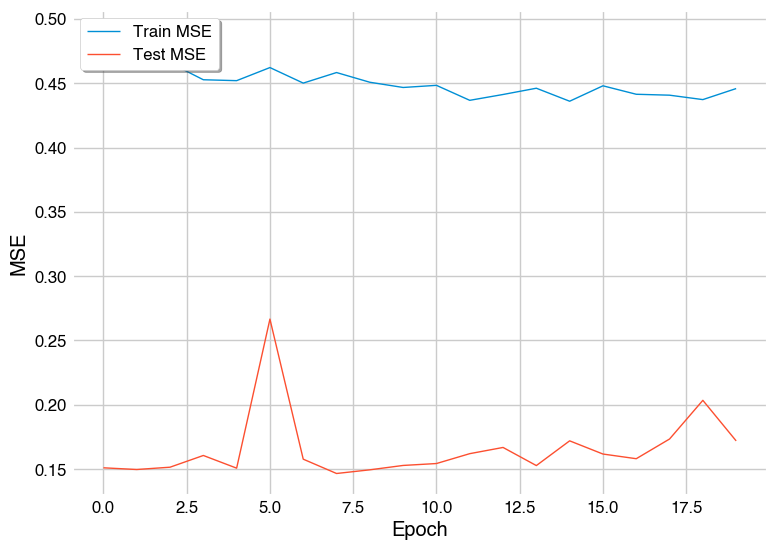

In [37]:
if overwrite or not os.path.exists(best_model_path):
    print(f"Model was saved to {best_model_path}")
    best_model.save(best_model_path)
else:
    print(f"Model file already exists at {best_model_path}. Set 'overwrite=True' to overwrite the file.")
    
utils.plot_mse_over_epochs(History, plots_path, overwrite)

588/588 [==============================] - 3s 5ms/step
Root Mean Squared Error: 0.43781715629050694
R2 Score: 0.5802425168132586
88/88 [==============================] - 0s 5ms/step
Root Mean Squared Error: 0.2800986604822903
R2 Score: 0.005515987756277485
File Predictions.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lstm/whole-V3/Predictions.pdf.


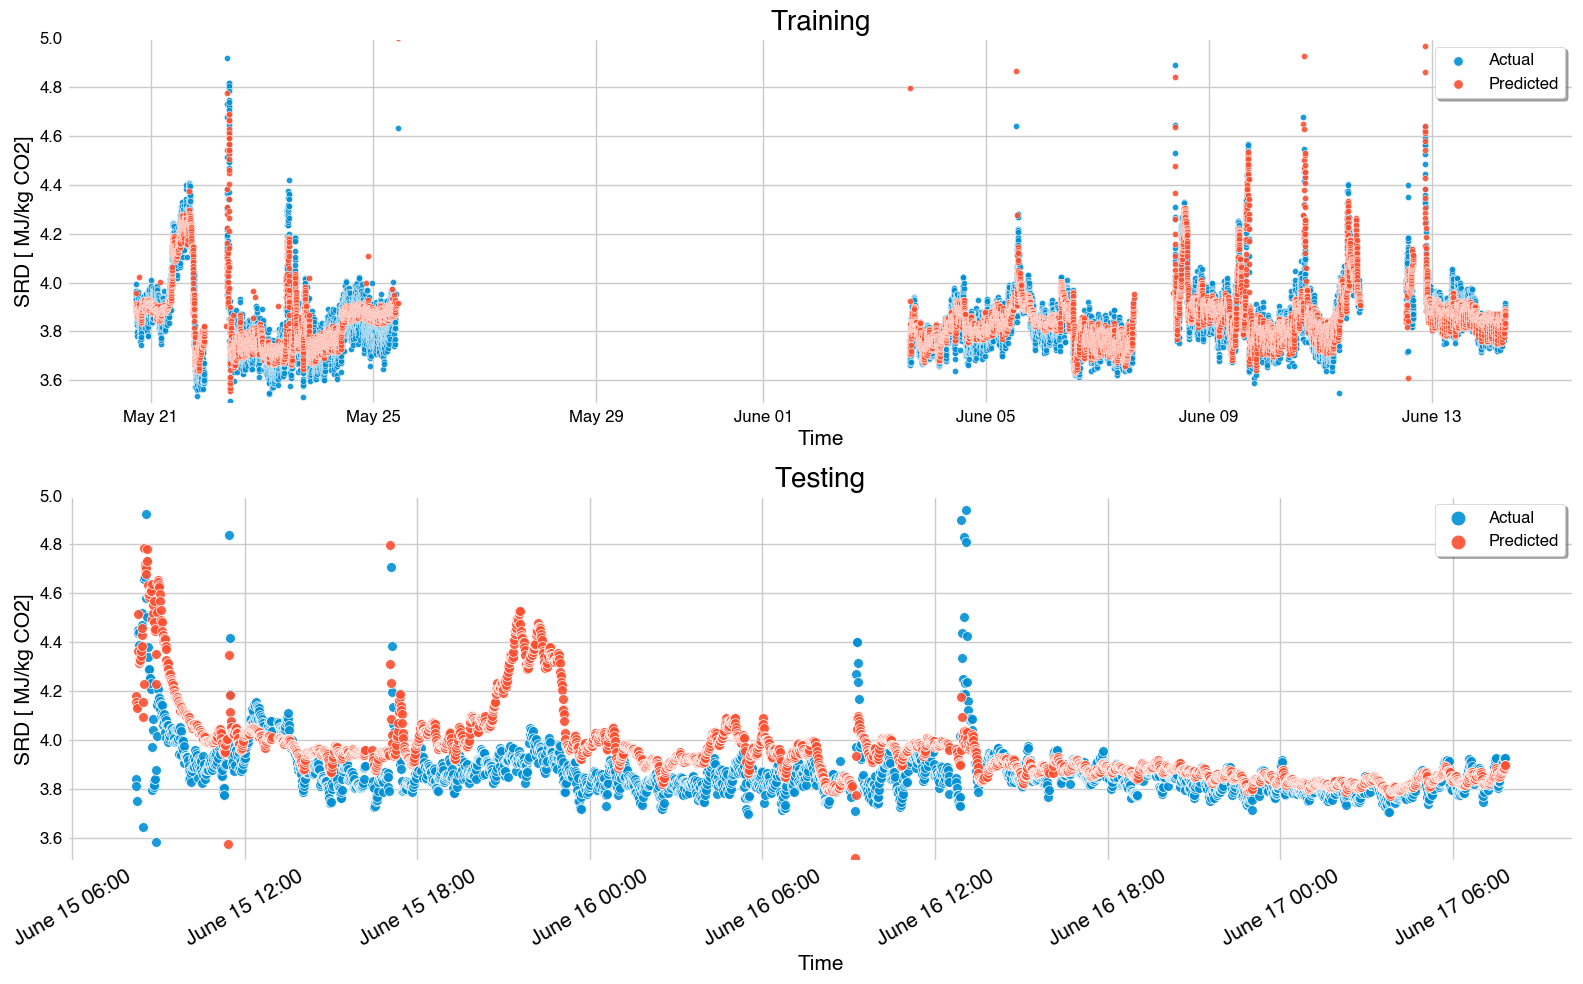

In [10]:
def prediction_df(model, scaler, X_seq, y_seq, times):
    y_pred = model.predict(X_seq)
    y_pred = scaler.inverse_transform(y_pred).reshape(-1)
    y_actual = scaler.inverse_transform(y_seq).reshape(-1)

    df_res = pd.DataFrame({'Time': times, 
                           'Actual': y_actual, 
                           'Predicted': y_pred})
    df_res.sort_values('Time')
    
    rmse = mean_squared_error(df_res['Actual'], df_res['Predicted'], squared=False)
    r2 = r2_score(df_res['Actual'], df_res['Predicted'])
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 Score: {r2}")
    
    return df_res, rmse

loaded_model = keras.models.load_model(best_model_path)
df_train, rmse_train = prediction_df(loaded_model, scaler, X_train_seq, y_train_seq, times_train)
df_test, rmse_test = prediction_df(loaded_model, scaler, X_test_seq, y_test_seq, times_test)

utils.plot_time_predictions(df_train, df_test, plots_path, overwrite, limit=[3.5, 5])

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File Parity_plot_LSTM-whole_data.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lstm/whole-V3/Parity_plot_LSTM-whole_data.pdf.


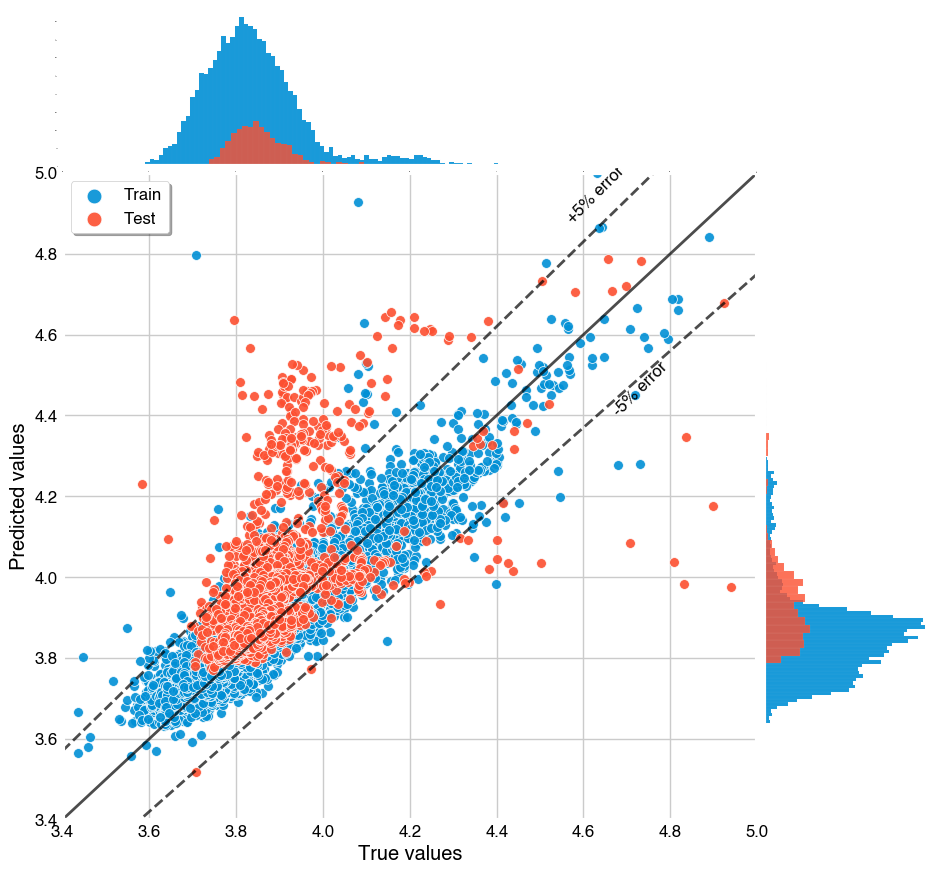

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File Residuals_plot_LSTM-whole_data.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lstm/whole-V3/Residuals_plot_LSTM-whole_data.pdf.


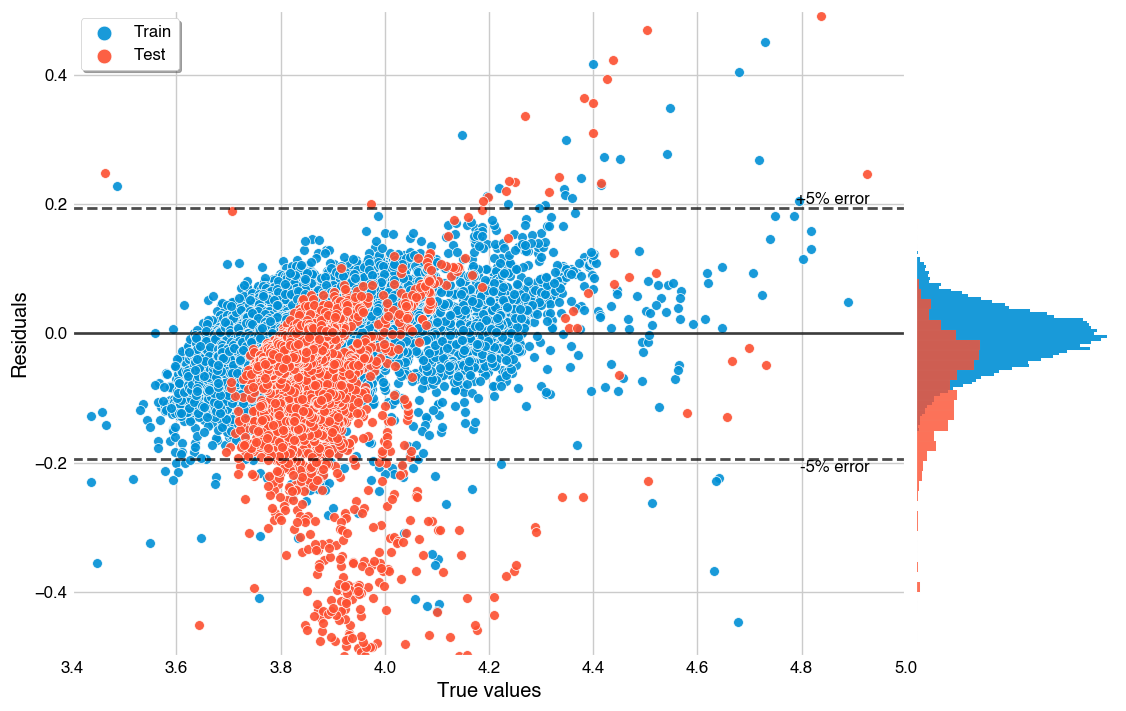

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File KDE_plot_LSTM-whole_data.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lstm/whole-V3/KDE_plot_LSTM-whole_data.pdf.


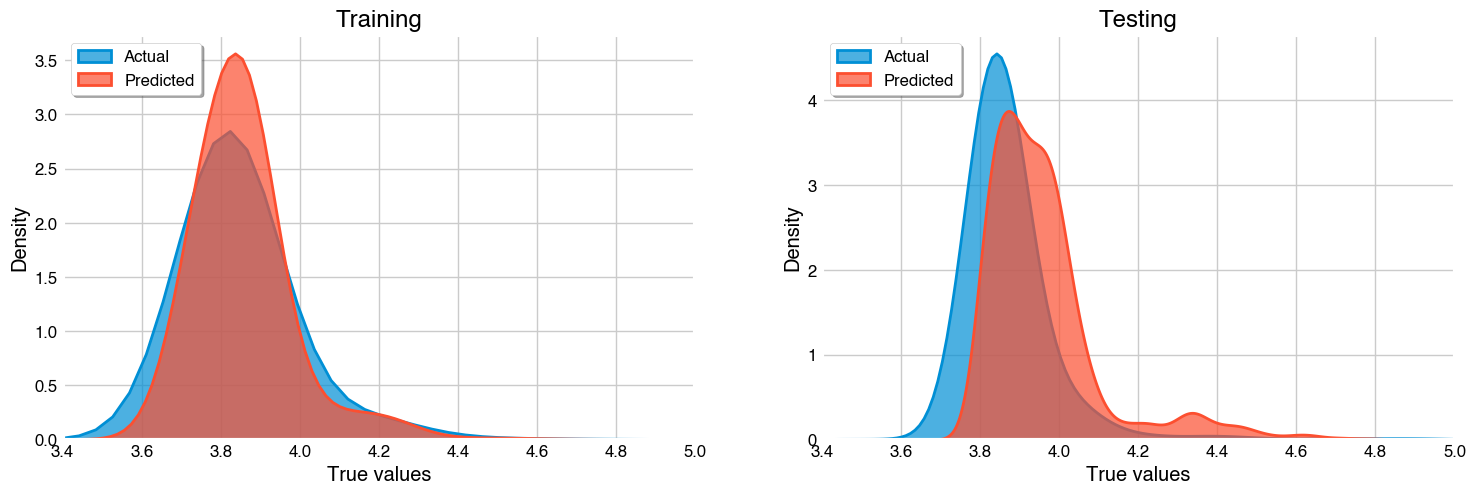

In [40]:
utils.make_evaluation_plots(df_train,
                            df_test,
                            'LSTM-whole_data',
                            plots_path,
                            overwrite=True,
                            limit=[3.4, 5],
                            error_line=0.05,
                            res_limit=[-0.5, 0.5],
                            mean=pd.read_pickle("../data/processed/SRD_Lysekil.pkl")['SRD'].mean())